In [ ]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from aif360.datasets import BinaryLabelDataset
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.algorithms.preprocessing import Reweighing
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix,accuracy_score
from IPython.display import Markdown, display
from aif360.metrics import ClassificationMetric

### Data Understanding

In [67]:
df = pd.read_csv("heart.csv")
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0


In [13]:
print(df.shape)
df.info()

(1025, 14)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1025 entries, 0 to 1024
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1025 non-null   int64  
 1   sex       1025 non-null   int64  
 2   cp        1025 non-null   int64  
 3   trestbps  1025 non-null   int64  
 4   chol      1025 non-null   int64  
 5   fbs       1025 non-null   int64  
 6   restecg   1025 non-null   int64  
 7   thalach   1025 non-null   int64  
 8   exang     1025 non-null   int64  
 9   oldpeak   1025 non-null   float64
 10  slope     1025 non-null   int64  
 11  ca        1025 non-null   int64  
 12  thal      1025 non-null   int64  
 13  target    1025 non-null   int64  
dtypes: float64(1), int64(13)
memory usage: 112.2 KB


<Axes: title={'center': 'Age Distribution'}, ylabel='Frequency'>

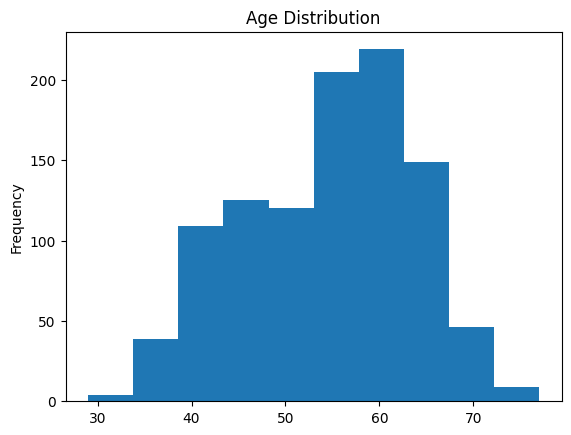

In [14]:
df['age'].plot(kind='hist',title='Age Distribution')

In [5]:
display(Markdown("#### Dataset is largely unbalanced with almost 70% male"))
gender_distribution = df['sex'].value_counts()
print(gender_distribution)

#### Dataset is largely unbalanced with almost 70% male

sex
1    713
0    312
Name: count, dtype: int64


In [15]:
display(Markdown("#### 1 indicates heart disease, 0 indicates no heart disease"))
heart_disease_distribution = df['target'].value_counts()
heart_disease_distribution 

#### 1 indicates heart disease, 0 indicates no heart disease

target
1    526
0    499
Name: count, dtype: int64

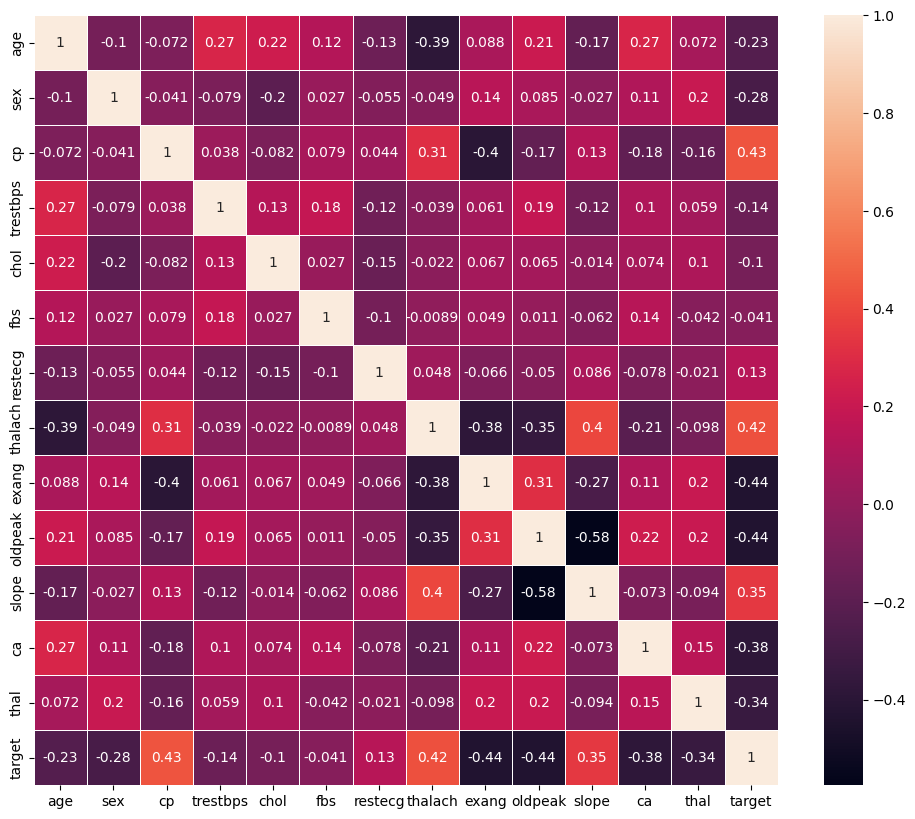

In [9]:
corr_m = df.corr()
plt.figure(figsize=(12,10))
sns.heatmap(corr_m, annot=True, linewidth=.5)
plt.show()

### Fairness Metrics Pre-training

In [58]:
# DF turned into BinaryLabelDataset to compute fairness metrics using AIF360
binary_label_dataset = BinaryLabelDataset(df=df, 
                                          label_names=['target'], # Predicted attribute (heart disease)
                                          protected_attribute_names=['sex'], 
                                          favorable_label=0, # Value 0: < 50% diameter narrowing – Indicates no significant heart disease
                                          unfavorable_label=1) # Value 1: > 50% diameter narrowing – Indicates the presence of heart disease


In [18]:
# Due to the significant class imbalance: females are in unprivileged group (0), males are in privileged group (1)
unprivileged_groups = [{'sex': 0}]
privileged_groups = [{'sex': 1}]

dataset_metric = BinaryLabelDatasetMetric(binary_label_dataset, 
                                            unprivileged_groups=unprivileged_groups,
                                            privileged_groups=privileged_groups)

##### Statistical parity difference (SPD): Negative value indicates benefits for females

##### Disparate impact ratio (DI), which is the ratio of positive outcomes in the unprivileged group vs positive outcomes in the unprivileged group. For this dataset, a positive outcome would be a 'target' value of 0, indicating no significant heart disease. A DI of 80% to 100% is acceptable, however our dataset yields a DI of 47.57%, indicating bias towards males

In [8]:
print("Statistical parity difference =", (dataset_metric.statistical_parity_difference()))
print("Disparate Impact =", (dataset_metric.disparate_impact()))

Statistical parity difference = -0.3036016111051174
Disparate Impact = 0.4758645309492767


### Training

In [68]:
y = df["target"] # feature we are predicting 
X = df.drop('target',axis=1) # using all other features for training/testing purposes 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state = 42)

In [69]:
# utilizing grid search to help find the most optimal hyperparameters for random forest classification 
rf = RandomForestClassifier()

param_grid = {
    'n_estimators': [25, 50, 75, 100], 
    'max_depth': [3, 5, 10, None],
    'max_features': ['sqrt', 'log2', None]
    }

grid_search_rf = GridSearchCV(rf, param_grid=param_grid) 

grid_search_rf.fit(X_train, y_train) 

print('Best parameters:', grid_search_rf.best_params_)
print('Best score:', grid_search_rf.best_score_)

Best parameters: {'max_depth': 10, 'max_features': 'log2', 'n_estimators': 25}
Best score: 0.9829268292682928


In [70]:
# making predictions on the test set
y_pred = grid_search_rf.predict(X_test)

In [71]:
# evaluation metrics:
# Using precision & recall since this model is predicting a diagnosis 
# high recall is necessary in this case to avoid misdiagnosing a person who actually has
# heart disease
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.9853658536585366
Precision: 1.0
Recall: 0.970873786407767


True Negatives (TN): 102
False Positives (FP): 0
False Negatives (FN): 3
True Positives (TP): 100


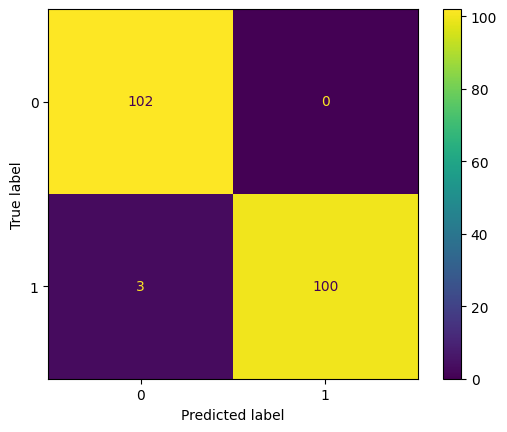

In [72]:
# creating a confusion matrix to further see the breakdown of true/false negatives and positives 
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()
tn, fp, fn, tp = cm.ravel()
print("True Negatives (TN):", tn)
print("False Positives (FP):", fp)
print("False Negatives (FN):", fn)
print("True Positives (TP):", tp)

### Fairness Metrics Post-training

In [73]:
columns = [
    'age', 
    'sex', 
    'cp', 
    'trestbps', 
    'chol', 
    'fbs', 
    'restecg', 
    'thalach', 
    'exang', 
    'oldpeak', 
    'slope', 
    'ca', 
    'thal', 
]

# dataframe containing the groud truth data with target values from the test set 
X_truth_df = pd.DataFrame(X_test, columns=columns)
X_truth_df['target'] = y_test

binary_ground_truth = BinaryLabelDataset(
    df=X_truth_df,
    label_names=['target'],
    protected_attribute_names=['sex'],
    favorable_label=0, 
    unfavorable_label=1 
)
# dataframe containing the original data values with the predicted target values 
X_pred_df = pd.DataFrame(X_test, columns=columns)
X_pred_df['target'] = y_pred

# creating a classified dataset based on the ground truth and predictions from the test set
# this will be used to calculate additional metrics after training 
binary_pred = BinaryLabelDataset(
    df=X_pred_df,
    label_names=['target'],
    protected_attribute_names=['sex'],
    favorable_label=0, 
    unfavorable_label=1 
)

##### AOD is the average of difference in false/true positive rates in privileged/unplivileged groups. A score above 0 suggests benefits for Females. 
##### TI measures group/individual fairness. Our dataset has a very low TI, thus classification outcomes are distributed more equitably. 
##### EOD is the difference in true positive rates between privileged and unprivileged groups. 0 indicates perfect fairness. 


In [74]:
# creating an AIF360 classification metric to calculate metrics on the ground truth vs predictions
classification_dataset_metric = ClassificationMetric(
    dataset=binary_ground_truth,
    classified_dataset=binary_pred,
    privileged_groups=privileged_groups,
    unprivileged_groups=unprivileged_groups
)

print("Average Odds Difference:", classification_dataset_metric.average_odds_difference())
print("Thiel Index:", classification_dataset_metric.theil_index())
print("Equal Opportunity Difference:", classification_dataset_metric.equal_opportunity_difference())

Average Odds Difference: 0.030612244897959183
Thiel Index: 0.005466529645550109
Equal Opportunity Difference: 0.0


### Fairness metrics after reweighing pre-training

In [78]:
# creating a test and train dataset with same split as before 
dataset_train, dataset_test = binary_label_dataset.split([0.8], shuffle=True)

privileged_groups = [{'sex': 1}]
unprivileged_groups = [{'sex': 0}]

# utilizing AIF360's reweighing algorithm which will adjust the dataset to have more weight on positive outcomes on sex for males and females
RW = Reweighing(unprivileged_groups=unprivileged_groups,
                privileged_groups=privileged_groups)

dataset_transf_train = RW.fit_transform(dataset_train)
dataset_transf_test = RW.fit_transform(dataset_test)

##### SPD is so small it is practically 0.
##### DI is close to 1.
##### Reweighing is effective in increasing fariness in our dataset in both training and testing splits

In [79]:
metric_transf_train = BinaryLabelDatasetMetric(dataset_transf_train, 
                                               unprivileged_groups=unprivileged_groups,
                                               privileged_groups=privileged_groups)

display(Markdown("#### Transformed training dataset"))
print("Statistical parity difference =", metric_transf_train.statistical_parity_difference())
print("Disparate Impact =", metric_transf_train.disparate_impact())

#### Transformed training dataset

Statistical parity difference = 1.1102230246251565e-16
Disparate Impact = 1.0000000000000002


In [80]:
metric_transf_test = BinaryLabelDatasetMetric(dataset_transf_test, 
                                               unprivileged_groups=unprivileged_groups,
                                               privileged_groups=privileged_groups)

display(Markdown("#### Transformed testing dataset"))
print("Statistical parity difference =", metric_transf_test.statistical_parity_difference())
print("Disparate Impact =", metric_transf_test.disparate_impact())

#### Transformed testing dataset

Statistical parity difference = -1.1102230246251565e-16
Disparate Impact = 0.9999999999999998


### Training after reweighing

In [81]:
X_train_rw = dataset_transf_train.features
y_train_rw = dataset_transf_train.labels.ravel()
X_test_rw = dataset_transf_test.features
y_test_rw = dataset_transf_test.labels.ravel()
weights_rw = dataset_transf_train.instance_weights

In [82]:
# performing grid search again 
rf_rw = RandomForestClassifier()

param_grid = {
    'n_estimators': [25, 50, 75, 100], 
    'max_depth': [3, 5, 10, None],
    'max_features': ['sqrt', 'log2', None]
    }

grid_search_rf_rw = GridSearchCV(rf_rw, param_grid=param_grid) 

grid_search_rf_rw.fit(X_train_rw, y_train_rw, sample_weight=weights_rw) 

print('Best parameters:', grid_search_rf_rw.best_params_)
print('Best score:', grid_search_rf_rw.best_score_)

Best parameters: {'max_depth': None, 'max_features': 'log2', 'n_estimators': 50}
Best score: 0.9902439024390244


In [83]:
y_pred_rw = grid_search_rf_rw.predict(X_test_rw)

In [84]:
# using the same evaluation methods 
accuracy = accuracy_score(y_test_rw, y_pred_rw)
precision = precision_score(y_test_rw, y_pred_rw)
recall = recall_score(y_test_rw, y_pred_rw)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 1.0
Precision: 1.0
Recall: 1.0


True Negatives (TN): 106
False Positives (FP): 0
False Negatives (FN): 0
True Positives (TP): 99


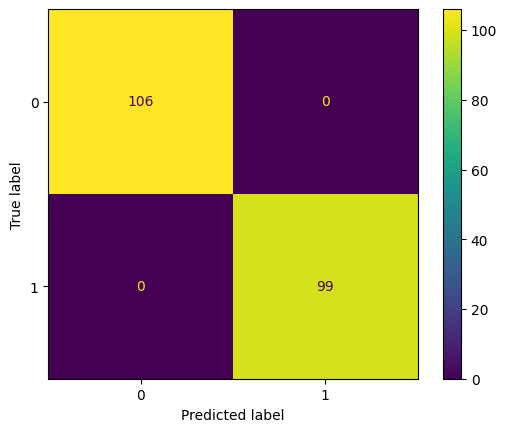

In [85]:
# creating a confusion matrix to further see the breakdown of true/false negatives and positives 
cm = confusion_matrix(y_test_rw, y_pred_rw)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()
tn, fp, fn, tp = cm.ravel()
print("True Negatives (TN):", tn)
print("False Positives (FP):", fp)
print("False Negatives (FN):", fn)
print("True Positives (TP):", tp)

### Fairness metrics after reweighing post-training

In [86]:
X_truth_rw_df = pd.DataFrame(X_test_rw, columns=columns)
X_truth_rw_df['target'] = y_test_rw

binary_ground_truth_rw = BinaryLabelDataset(
    df=X_truth_rw_df,
    label_names=['target'],
    protected_attribute_names=['sex'],
    favorable_label=0, 
    unfavorable_label=1 
)

X_pred_rw_df = pd.DataFrame(X_test_rw, columns=columns)
X_pred_rw_df['target'] = y_pred_rw

binary_pred_rw = BinaryLabelDataset(
    df=X_pred_rw_df,
    label_names=['target'],
    protected_attribute_names=['sex'],
    favorable_label=0, 
    unfavorable_label=1 
)

##### Post training metrics are 0 than prior to reweighing, indicating perfect fairness

In [87]:
classification_dataset_metric_rw = ClassificationMetric(
    dataset=binary_ground_truth_rw,
    classified_dataset=binary_pred_rw,
    privileged_groups=privileged_groups,
    unprivileged_groups=unprivileged_groups
)

print("Average Odds Difference:", classification_dataset_metric_rw.average_odds_difference())
print("Thiel Difference:", classification_dataset_metric_rw.theil_index())
print("Equal Opportunity Difference:", classification_dataset_metric_rw.equal_opportunity_difference())

Average Odds Difference: 0.0
Thiel Difference: 0.0
Equal Opportunity Difference: 0.0
